## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import entropy, anderson

## Loading in Datasets

In [2]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

In [3]:
ARIMA_forecast = pd.read_csv('datasets/ARIMA/ARIMA_forecast.csv', index_col=0, parse_dates=['date'])
AR_forecast = pd.read_csv('datasets/AR/AR_forecast.csv', index_col=0, parse_dates=['date'])
ARCH_forecast = pd.read_csv('datasets/ARCH/ARCH_forecast.csv', index_col=0, parse_dates=['date'])
GARCH_forecast = pd.read_csv('datasets/GARCH/GARCH_forecast.csv', index_col=0, parse_dates=['date'])
GJR_GARCH_forecast = pd.read_csv('datasets/GJR_GARCH/GJR_GARCH_forecast.csv', index_col=0, parse_dates=['date'])

In [4]:
def panelDFtoDict(panelDF):
    all_ticks = panelDF['tick'].unique()
    tDFdict = dict()
    for tick in all_ticks:
        tDF = panelDF[panelDF['tick'] == tick]
        tDFdict[tick] = tDF.set_index('date')
    return tDFdict

ARIMA_tDF = panelDFtoDict(ARIMA_forecast)
AR_tDF = panelDFtoDict(AR_forecast)
ARCH_tDF = panelDFtoDict(ARCH_forecast)
GARCH_tDF = panelDFtoDict(GARCH_forecast)
GJR_GARCH_tDF = panelDFtoDict(GJR_GARCH_forecast)

## Defining a Loss Function

The loss function used here is the **Mean Squared Error (MSE)**, calculated as:

$$\text{Loss} = \frac{1}{2}(\hat{y} - y)^2$$

Where:
$\\    \hat{y} \text{ is the predicted value (forecasted value).}\\$
$y     \text{ is the actual observed value.}$

In [5]:
def loss_function(yhat, y):
    return  np.sum((y - yhat) ** 2)/len(yhat)

In [6]:
# print(f'The average loss is: {np.mean(loss_function(preds, actual)):.3f}')
# print(f'The total loss is:   {np.sum(loss_function(preds, actual)):.3f}')

In [7]:
def percentage_loss(yhat, y):
    return np.abs(yhat - y) / y * 100

In [8]:
# print(f'Average loss of: {np.mean(percentage_loss(preds, actual)):.2f}%')

In [9]:
def log_likelihood(yhat, y):
    residuals = y - yhat
    sigma_squared = np.var(residuals)
    n = len(actual)
    log_likelihood_value = (-n / 2) * np.log(2 * np.pi * sigma_squared) - (1 / (2 * sigma_squared)) * np.sum(residuals ** 2)

    return log_likelihood_value

## Goodness of Fit

In [10]:
def r_score(yhat, y):
    return r2_score(yhat, y)

# print(f'The goodness of fit with an R^2 score of: {r_score(preds, actual):.3f}.\nThis indicates an accuracy of: {r_score(preds, actual) * 100:.2f}%')

## Plotting

In [11]:
def plot_actual_prediction_residuals(actual, preds):
    residuals = actual - preds

    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, actual, color='b', label='Actual Data', marker='o')
    plt.plot(preds.index, preds, color='r', label='Predicted Data', linestyle='dashed', marker='x')
    plt.title('Actual vs Predicted')
    plt.xlabel('Year')
    plt.ylabel('CDS Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, residuals, color='g', label='Residuals', marker='x')
    plt.axhline(0, color='black', linestyle='dashed')
    plt.title('Residuals')
    plt.xlabel('Year')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

In [12]:
# plot_actual_prediction_residuals(actual, preds)

## Kolmogorov-Smirnov Test

In [13]:
def perform_ks_test_actual_vs_preds(actual, preds):
    ks_stat, p_value = stats.ks_2samp(actual, preds)

    print(f"KS Statistic: {ks_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

    if p_value > 0.05:
        print("The actual and predicted data likely come from the same distribution (fail to reject H0).")
    else:
        print("The actual and predicted data do not come from the same distribution (reject H0).")

# perform_ks_test_actual_vs_preds(actual, preds)

## Anderson-Darling Test

In [14]:
# print(anderson(actual-preds))

## Kullback–Leibler (KL) divergence

In [15]:
# kl_divergence = entropy(actual, preds)
# print(kl_divergence)

## Coverage Probability

In [16]:
def calculate_picp(actual, lower_bounds, upper_bounds):
    within_bounds = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    picp = np.mean(within_bounds)
    return picp

In [17]:
def generate_prediction_intervals(actual, preds):
    margin = np.std(actual - preds) * 1.96  # for 95% CI

    lower_bounds = preds - margin
    upper_bounds = preds + margin

    return lower_bounds, upper_bounds

In [18]:
# lower_bounds, upper_bounds = generate_prediction_intervals(actual, preds)
# picp_value = calculate_picp(actual, lower_bounds, upper_bounds)

# print(f"Prediction Interval Coverage Probability (PICP) for 95% CI: {picp_value:.4f}.\nThis means {picp_value*100:.2f}% of the data falls within the 95% CI.")

In [19]:
def plot_actual_prediction_ci(actual, lower_bounds, upper_bounds):
    inside_ci = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    plt.figure(figsize=(15, 8))

    plt.scatter(actual.index[~inside_ci], actual[~inside_ci], color='r', label='Actual outside CI')
    plt.fill_between(actual.index, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.xlabel('Year')
    plt.ylabel('CDS Spread')
    plt.title('Actual vs Predicted with 95% Confidence Interval')
    plt.legend()
    plt.show()

In [20]:
# plot_actual_prediction_ci(actual, lower_bounds, upper_bounds)

## Mean Interval Score

In [21]:
def calculate_mean_interval_score(actual, lower_bounds, upper_bounds, alpha=0.05):
    interval_width = upper_bounds - lower_bounds
    penalty_lower = np.maximum(0, lower_bounds - actual)
    penalty_upper = np.maximum(0, actual - upper_bounds)
    mis_values = interval_width + (2 / alpha) * (penalty_lower + penalty_upper)
    mis = np.mean(mis_values)

    return mis

In [22]:
# mis_value = calculate_mean_interval_score(actual, lower_bounds, upper_bounds)
# print(f"Mean Interval Score (MIS): {mis_value:.4f}")

## Calculating Statistics

In [23]:
def RMSE(yhat, y):
    """Calculates the Root Mean Squared Error """
    return  np.sqrt(np.sum((y - yhat) ** 2)/len(yhat))
def MAE(yhat, y, percentage=False):
    """Calculates the Mean Absolute Error """
    if percentage:
        return np.sum(np.abs((y - yhat)/y))/len(yhat) * 100
    return  np.sum(np.abs(y - yhat))/len(yhat)
def MPIW(upper_bounds, lower_bounds):
    """Calculates the Mean Prediction Interval Width"""
    return np.sum(upper_bounds - lower_bounds)/len(upper_bounds)
def PIS(actual, lower_bounds, upper_bounds):
    """Calculates the Prediction Interval Sharpness """
    return MPIW(upper_bounds, lower_bounds) * (1 - calculate_picp(actual, lower_bounds, upper_bounds))

In [24]:
RMSE_ARIMA = [RMSE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
RMSE_AR = [RMSE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
RMSE_ARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in ARCH_tDF.values()]
RMSE_GARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in GARCH_tDF.values()]
RMSE_GJR_GARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in GJR_GARCH_tDF.values()]

MAE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
MAE_AR = [MAE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
MAE_ARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in ARCH_tDF.values()]
MAE_GARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in GARCH_tDF.values()]
MAE_GJR_GARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in GJR_GARCH_tDF.values()]

MAPE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in ARIMA_tDF.values()]
MAPE_AR = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in AR_tDF.values()]
MAPE_ARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in ARCH_tDF.values()]
MAPE_GARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in GARCH_tDF.values()]
MAPE_GJR_GARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in GJR_GARCH_tDF.values()]

CR_ARIMA = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
CR_AR = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
CR_ARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARCH_tDF.values()]
CR_GARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GARCH_tDF.values()]
CR_GJR_GARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GJR_GARCH_tDF.values()]

PIS_ARIMA = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
PIS_AR = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
PIS_ARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARCH_tDF.values()]
PIS_GARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GARCH_tDF.values()]
PIS_GJR_GARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GJR_GARCH_tDF.values()]

In [25]:
print(f"Average RMSE for ARIMA: {np.mean(RMSE_AR):.5f}, AR: {np.mean(RMSE_ARIMA):.5f}")
print(f"Average MAE for ARIMA: {np.mean(MAE_ARIMA):.5f}, AR: {np.mean(MAE_ARIMA):.5f}")
print(f"Average MAPE for ARIMA: {np.mean(MAPE_ARIMA):.5f}, AR: {np.mean(MAPE_ARIMA):.5f}")
print(f"Average CR for ARIMA: {np.mean(CR_ARIMA):.5f}, AR: {np.mean(CR_AR):.5f}")
print(f"Average PIS for ARIMA: {np.mean(PIS_ARIMA):.5f}, AR: {np.mean(PIS_AR):.5f}")

Average RMSE for ARIMA: 5.33009, AR: 5.39330
Average MAE for ARIMA: 2.48767, AR: 2.48767
Average MAPE for ARIMA: 4.47558, AR: 4.47558
Average CR for ARIMA: 0.87465, AR: 0.87747
Average PIS for ARIMA: 0.97860, AR: 0.96082


In [26]:
print("ARIMA Statistics:")
print(f"Average RMSE: {np.mean(RMSE_ARIMA):.5f}")
print(f"Average MAE: {np.mean(MAE_ARIMA):.5f}")
print(f"Average MAPE: {np.mean(MAPE_ARIMA):.5f}")
print(f"Average CR: {np.mean(CR_ARIMA):.5f}")
print(f"Average PIS: {np.mean(PIS_ARIMA):.5f}")

ARIMA Statistics:
Average RMSE: 5.39330
Average MAE: 2.48767
Average MAPE: 4.47558
Average CR: 0.87465
Average PIS: 0.97860


In [27]:
print("AR Statistics:")
print(f"Average RMSE: {np.mean(RMSE_AR):.5f}")
print(f"Average MAE: {np.mean(MAE_AR):.5f}")
print(f"Average MAPE: {np.mean(MAPE_AR):.5f}")
print(f"Average CR: {np.mean(CR_AR):.5f}")
print(f"Average PIS: {np.mean(PIS_AR):.5f}")

AR Statistics:
Average RMSE: 5.33009
Average MAE: 2.44041
Average MAPE: 4.40398
Average CR: 0.87747
Average PIS: 0.96082


In [28]:
print("ARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_ARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_ARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_ARCH):.5f}")
print(f"Average CR: {np.mean(CR_ARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_ARCH):.5f}")

ARCH Statistics:
Average RMSE: 5.26768
Average MAE: 2.40382
Average MAPE: 4.38882
Average CR: 0.32335
Average PIS: 13.99125


In [29]:
print("GARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_GARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_GARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_GARCH):.5f}")
print(f"Average CR: {np.mean(CR_GARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_GARCH):.5f}")

GARCH Statistics:
Average RMSE: 5.26666
Average MAE: 2.40122
Average MAPE: 4.38618
Average CR: 0.29249
Average PIS: 13.17397


In [30]:
print("GJR-GARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_GJR_GARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_GJR_GARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_GJR_GARCH):.5f}")
print(f"Average CR: {np.mean(CR_GJR_GARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_GJR_GARCH):.5f}")

GJR-GARCH Statistics:
Average RMSE: 5.26642
Average MAE: 2.40145
Average MAPE: 4.38556
Average CR: 0.29177
Average PIS: 13.05271


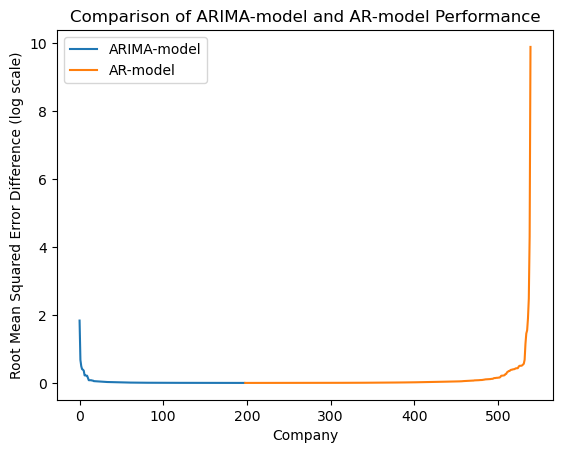

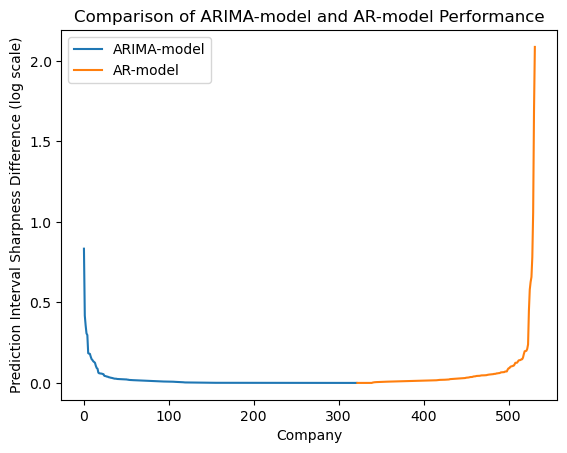

In [25]:
def sort_metrics_by_value(ticks, metric_scores):
    metrics_dict = {tick: score for tick, score in zip(ticks, metric_scores)}
    return dict(sorted(metrics_dict.items(), key=lambda item: item[1]))

def plot_model_comparison(ticks, metric_diff, metric, model_1_label="Model 1", model_2_label="Model 2"):
    sorted_dict = sort_metrics_by_value(ticks, metric_diff)
    sorted_metric_diff = np.array(list(sorted_dict.values()))
    m1_perform_better = {tick:np.abs(value) for tick,value in sorted_dict.items() if value > 0}
    m2_perform_better = {tick:np.abs(value) for tick,value in sorted_dict.items() if value < 0}
    length_m1_better = len(m1_perform_better.keys())
    length_m2_better = len(m2_perform_better.keys())

    plt.plot(range(length_m2_better), np.array(list(m2_perform_better.values())), label=model_1_label)
    plt.plot(range(length_m2_better, length_m2_better + length_m1_better), 
             np.array(list(m1_perform_better.values())), label=model_2_label)
    
    plt.xlabel("Company")
    plt.ylabel(f"{metric} Difference (log scale)")
    plt.title(f"Comparison of {model_1_label} and {model_2_label} Performance")
    #plt.yscale("log")
    plt.legend()
    plt.show()

# Example usage:
rmse_diff = np.array(RMSE_ARIMA) - np.array(RMSE_AR)
plot_model_comparison(
    ticks=ARIMA_tDF.keys(),
    metric_diff=rmse_diff,
    model_1_label="ARIMA-model",
    model_2_label="AR-model",
    metric="Root Mean Squared Error"
)

pis_diff = np.array(PIS_ARIMA) - np.array(PIS_AR)
plot_model_comparison(
    ticks=ARIMA_tDF.keys(),
    metric_diff=pis_diff,
    model_1_label="ARIMA-model",
    model_2_label="AR-model",
    metric="Prediction Interval Sharpness"
)

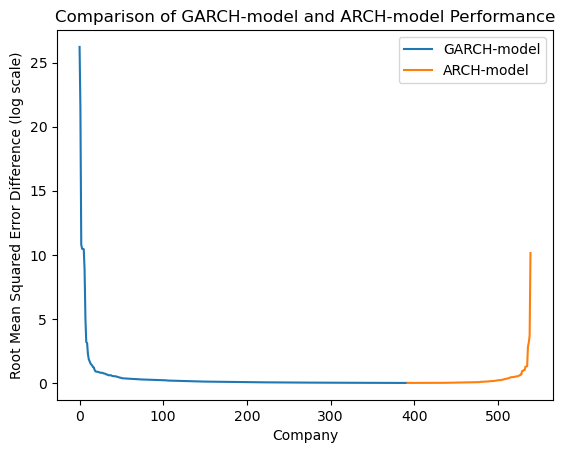

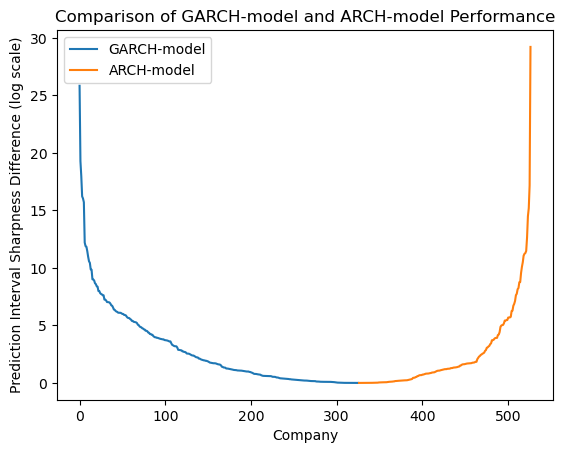

In [26]:
# ARCH vs GARCH
rmse_diff_G_ARCH = np.array(RMSE_GARCH) - np.array(RMSE_ARCH)
plot_model_comparison(
    ticks=GARCH_tDF.keys(),
    metric_diff=rmse_diff_G_ARCH,
    model_1_label="GARCH-model",
    model_2_label="ARCH-model",
    metric="Root Mean Squared Error"
)

pis_diff_G_ARCH = np.array(PIS_GARCH) - np.array(PIS_ARCH)
plot_model_comparison(
    ticks=GARCH_tDF.keys(),
    metric_diff=pis_diff_G_ARCH,
    model_1_label="GARCH-model",
    model_2_label="ARCH-model",
    metric="Prediction Interval Sharpness"
)

#### Interpretation 
Interesting to see that both the RMSE and PIS metrics are relatively very close to eachother, but at the edges there are some cases where one model performed 'a lot' better than the other

In [27]:
def plot_top_differences(ticks, metric_diff, metric_name, model_1_label, model_2_label, top_n=20):
    sorted_indices = np.argsort(metric_diff)
    top_positive_indices = sorted_indices[-top_n:]
    top_negative_indices = sorted_indices[:top_n]

    top_positive_ticks = [ticks[i] for i in top_positive_indices]
    top_negative_ticks = [ticks[i] for i in top_negative_indices]

    top_positive_values = metric_diff[top_positive_indices]
    top_negative_values = metric_diff[top_negative_indices]

    plt.figure(figsize=(8, 10))
    plt.barh(top_positive_ticks, top_positive_values, color="blue", label=model_1_label)
    plt.barh(top_negative_ticks, -top_negative_values, color="red", label=model_2_label)
    plt.xlabel(f"{metric_name} Difference")
    plt.title(f"Top {top_n} {metric_name} Differences Between {model_1_label} and {model_2_label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

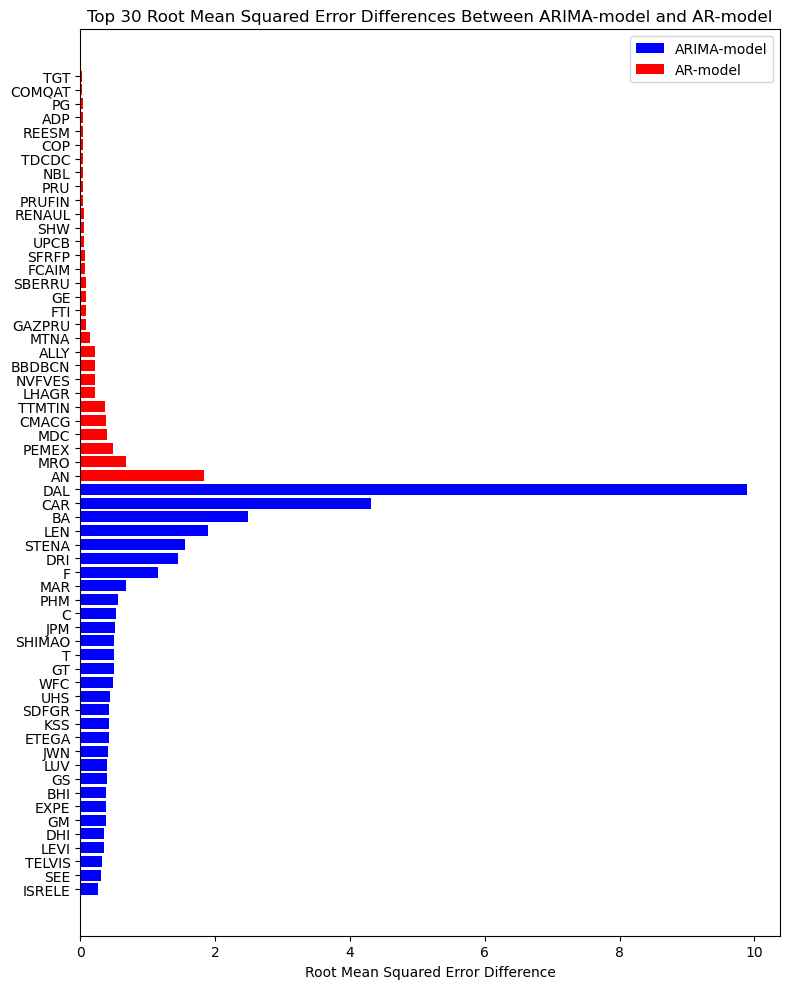

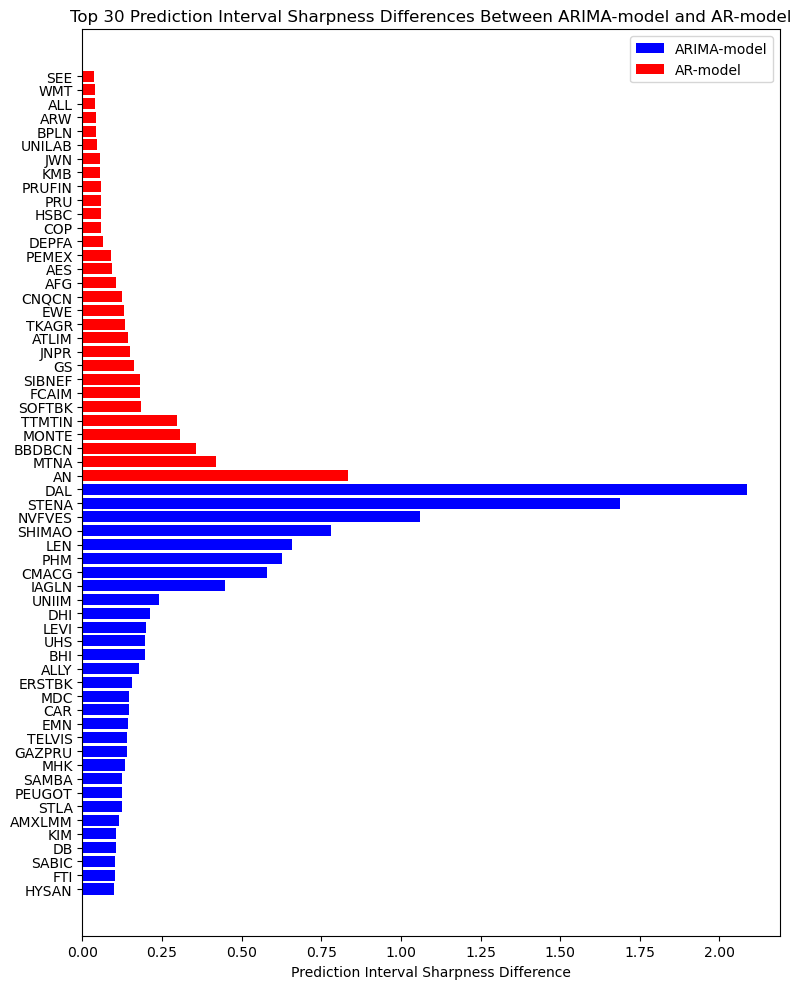

In [28]:
plot_top_differences(
    ticks=list(ARIMA_tDF.keys()),
    metric_diff=np.array(RMSE_ARIMA) - np.array(RMSE_AR),
    metric_name="Root Mean Squared Error",
    model_1_label="ARIMA-model",
    model_2_label="AR-model",
    top_n=30
)

plot_top_differences(
    ticks=list(ARIMA_tDF.keys()),
    metric_diff=np.array(PIS_ARIMA) - np.array(PIS_AR),
    metric_name="Prediction Interval Sharpness",
    model_1_label="ARIMA-model",
    model_2_label="AR-model",
    top_n=30
)

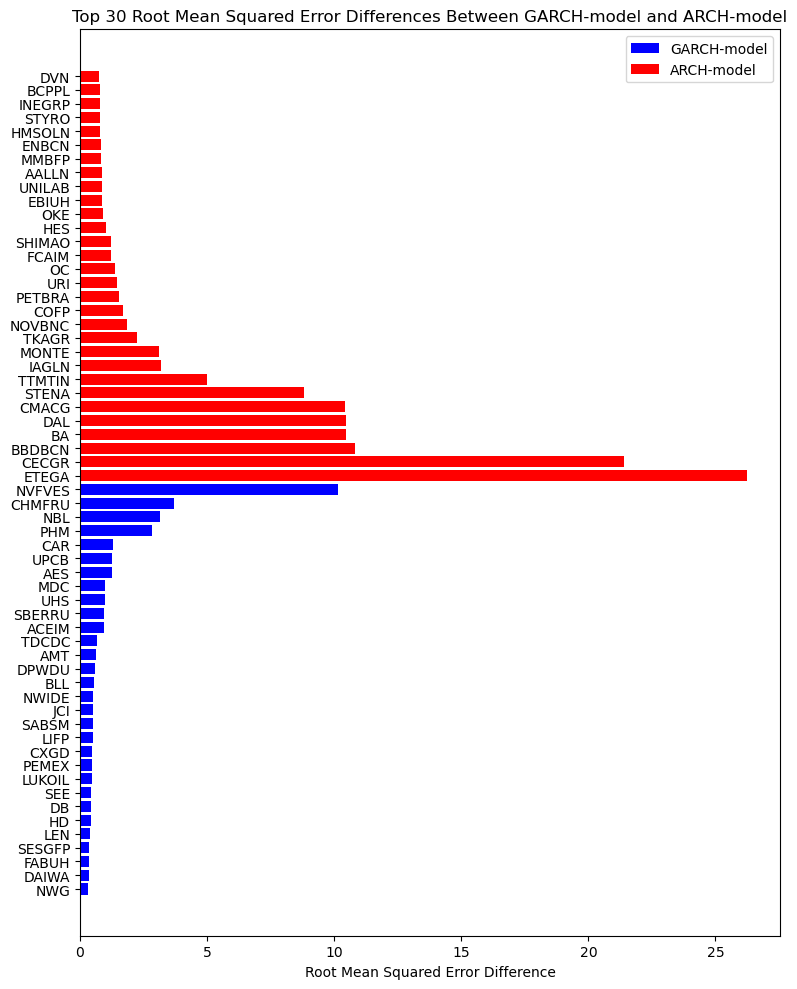

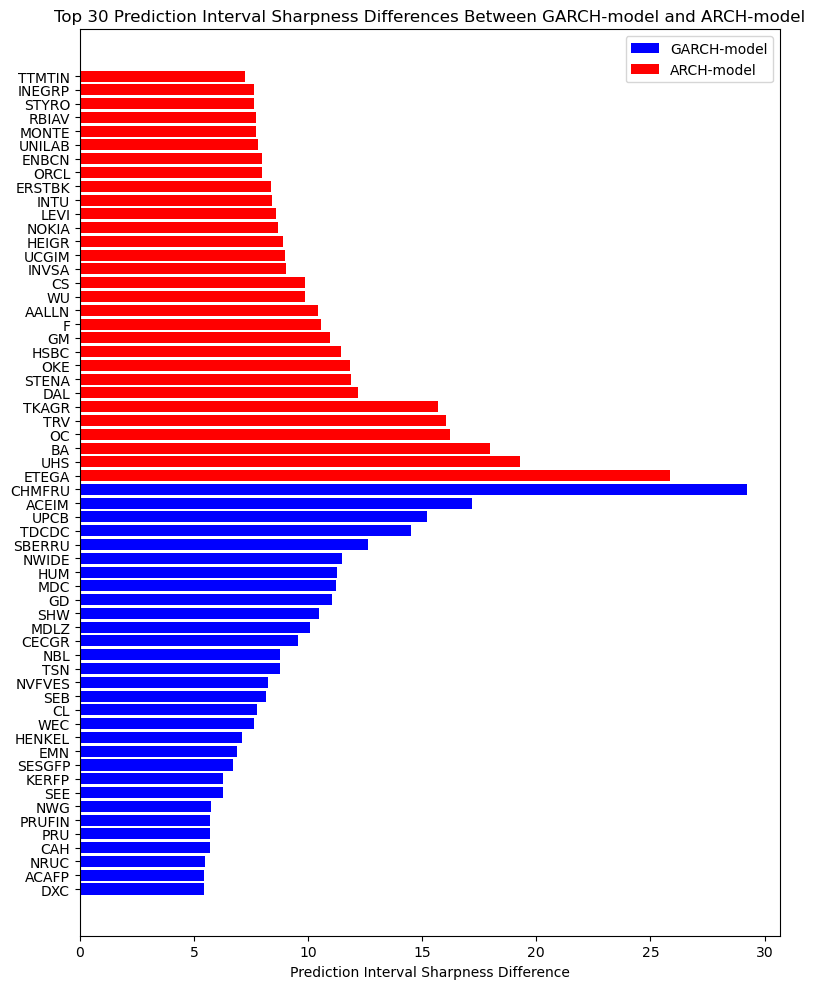

In [29]:
plot_top_differences(
    ticks=list(GARCH_tDF.keys()),
    metric_diff=np.array(RMSE_GARCH) - np.array(RMSE_ARCH),
    metric_name="Root Mean Squared Error",
    model_1_label="GARCH-model",
    model_2_label="ARCH-model",
    top_n=30
)

plot_top_differences(
    ticks=list(GARCH_tDF.keys()),
    metric_diff=np.array(PIS_GARCH) - np.array(PIS_ARCH),
    metric_name="Prediction Interval Sharpness",
    model_1_label="GARCH-model",
    model_2_label="ARCH-model",
    top_n=30
)

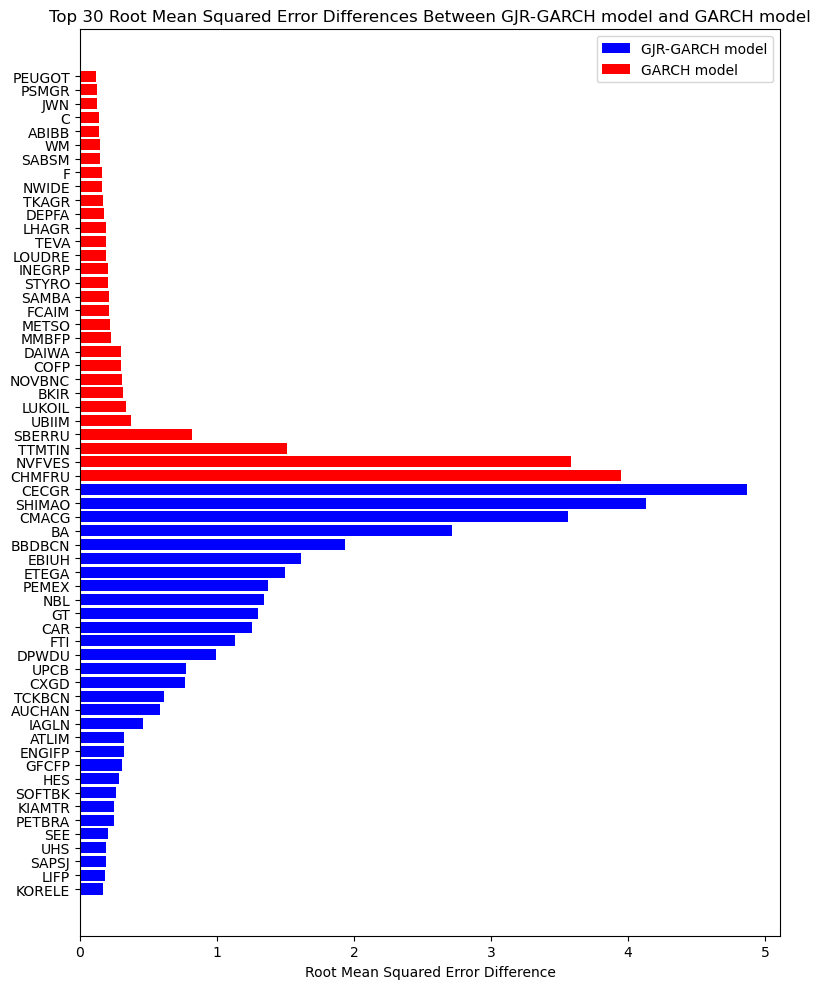

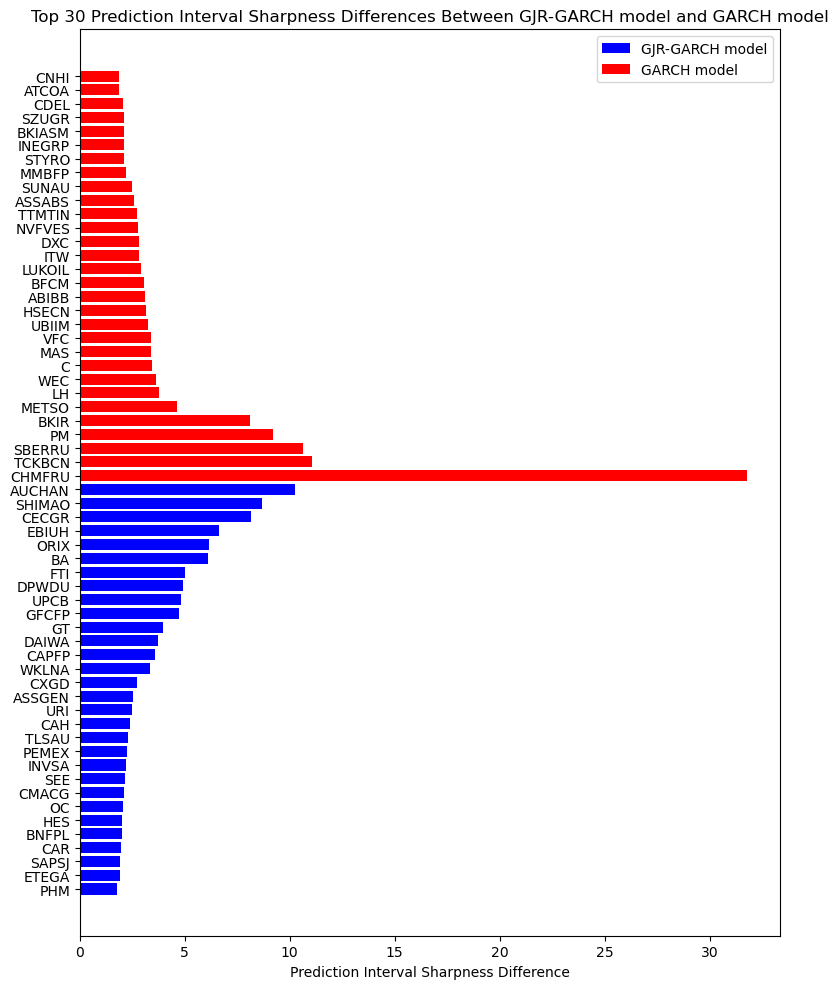

In [30]:
plot_top_differences(
    ticks=list(GJR_GARCH_tDF.keys()),
    metric_diff=np.array(RMSE_GJR_GARCH) - np.array(RMSE_GARCH),
    metric_name="Root Mean Squared Error",
    model_1_label="GJR-GARCH model",
    model_2_label="GARCH model",
    top_n=30
)

plot_top_differences(
    ticks=list(GJR_GARCH_tDF.keys()),
    metric_diff=np.array(PIS_GJR_GARCH) - np.array(PIS_GARCH),
    metric_name="Prediction Interval Sharpness",
    model_1_label="GJR-GARCH model",
    model_2_label="GARCH model",
    top_n=30
)

#### Interpretation 
For both the RMSE and PIS abosulet differences, the top differences are the same companies, lets investigate further:

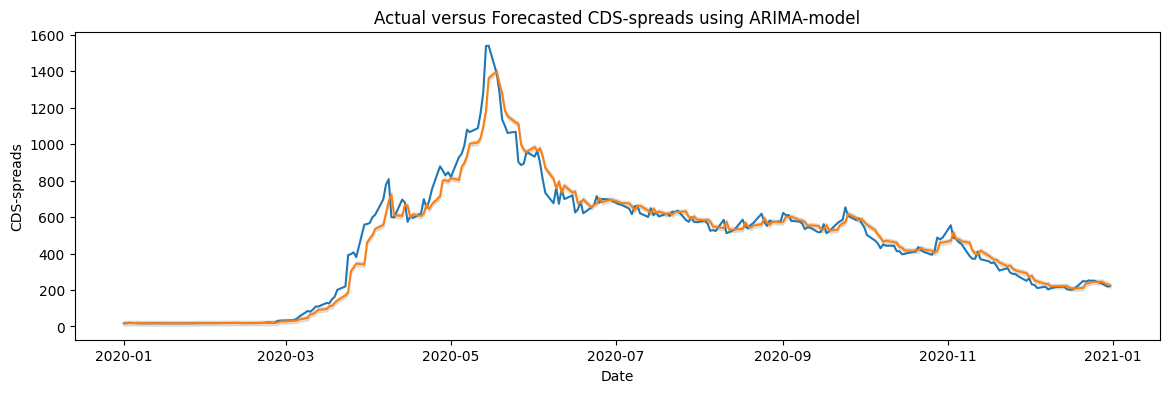

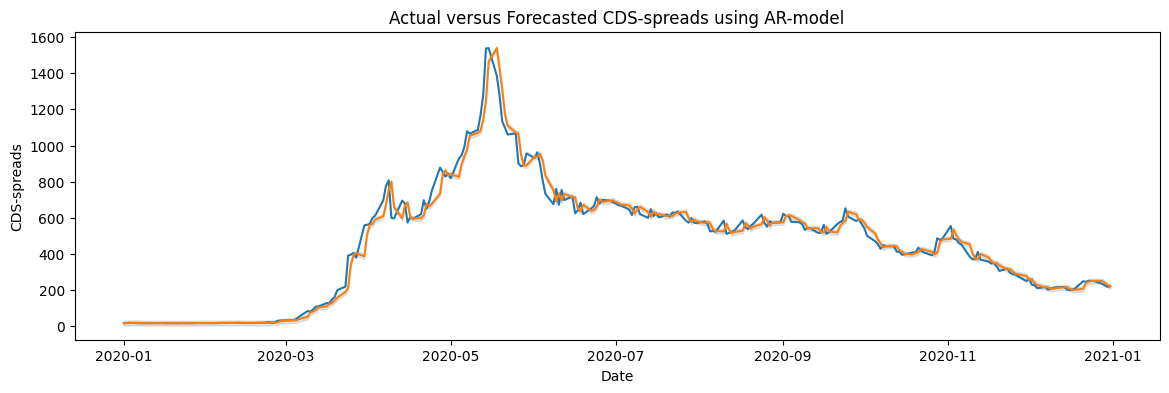

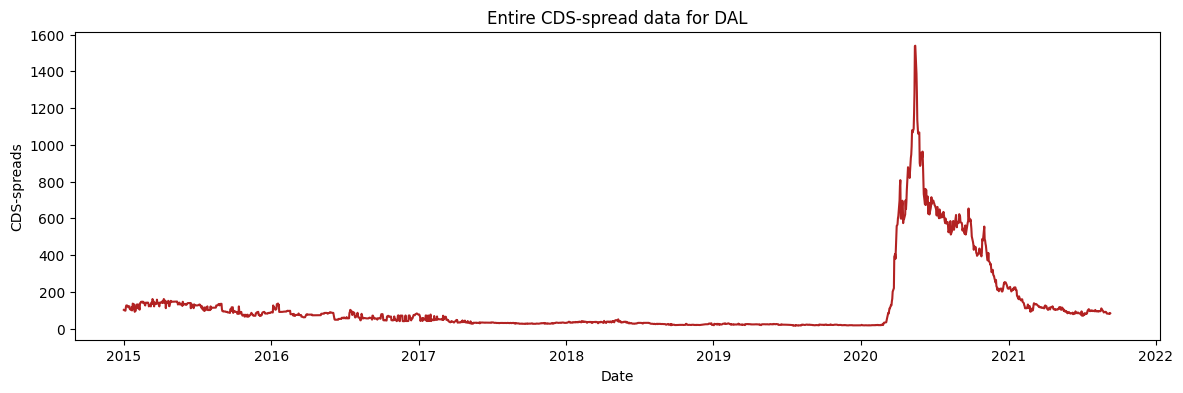

In [28]:
plt.figure(figsize=(14,4))
plt.plot(ARIMA_tDF['DAL']['actual'], label="Actual Data")
plt.plot(ARIMA_tDF['DAL']['preds'], label="Forecast")
plt.fill_between(ARIMA_tDF['DAL']['preds'].index, ARIMA_tDF['DAL']['lower_95'], ARIMA_tDF['DAL']['upper_95'], color='grey', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Actual versus Forecasted CDS-spreads using ARIMA-model")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(AR_tDF['DAL']['actual'], label="Actual Data")
plt.plot(AR_tDF['DAL']['preds'], label="Forecast")
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Actual versus Forecasted CDS-spreads using AR-model")
plt.fill_between(AR_tDF['DAL']['preds'].index, AR_tDF['DAL']['lower_95'], AR_tDF['DAL']['upper_95'], color='grey', alpha=0.2)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(ticks_DF_dict['DAL']['PX1'], color='firebrick')
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Entire CDS-spread data for DAL");

#### Interpretation 
DAL had a huge increase in CDS-spreads, so maybe that is why the AR-model performed better here?

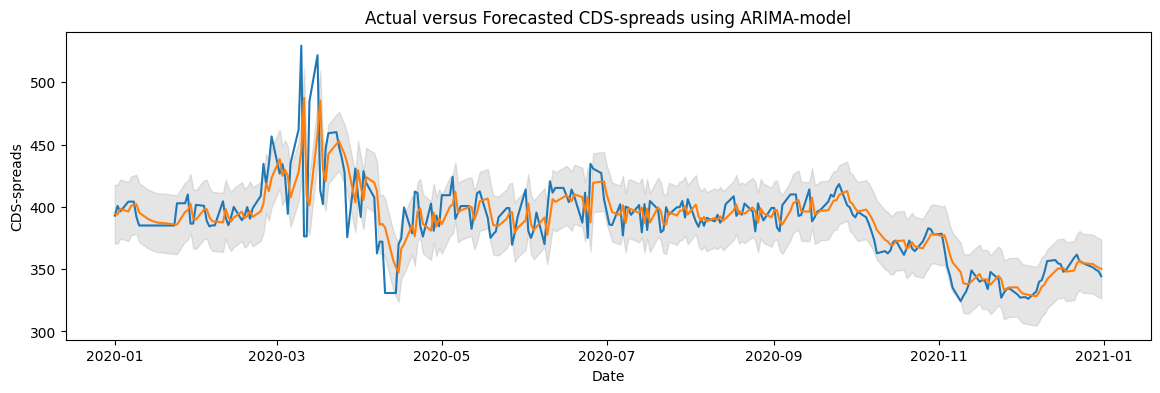

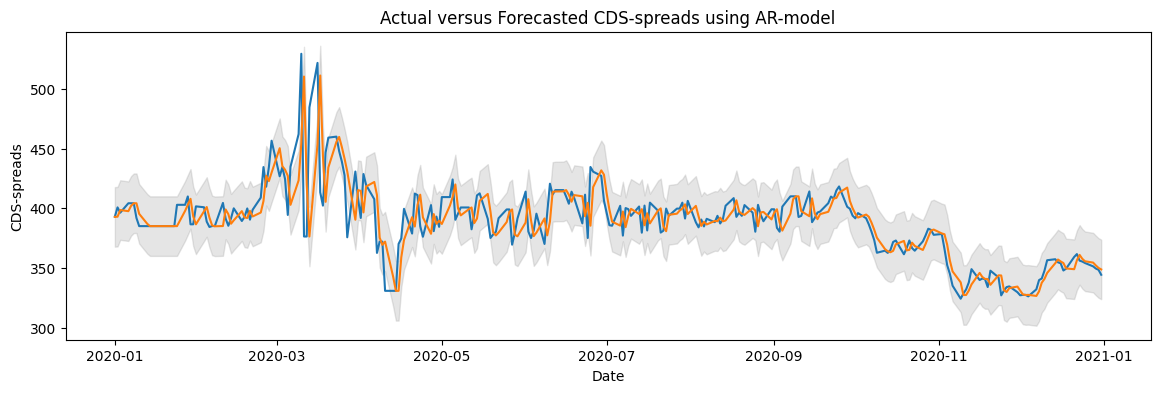

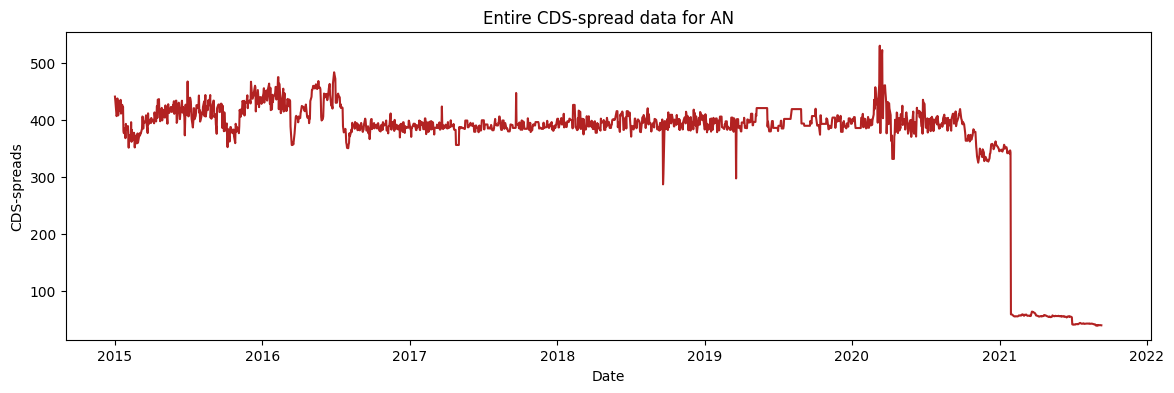

In [29]:
plt.figure(figsize=(14,4))
plt.plot(ARIMA_tDF['AN']['actual'])
plt.plot(ARIMA_tDF['AN']['preds'])
plt.fill_between(ARIMA_tDF['AN']['preds'].index, ARIMA_tDF['AN']['lower_95'], ARIMA_tDF['AN']['upper_95'], color='grey', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Actual versus Forecasted CDS-spreads using ARIMA-model")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(AR_tDF['AN']['actual'])
plt.plot(AR_tDF['AN']['preds'])
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Actual versus Forecasted CDS-spreads using AR-model")
plt.fill_between(AR_tDF['AN']['preds'].index, AR_tDF['AN']['lower_95'], AR_tDF['AN']['upper_95'], color='grey', alpha=0.2)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(ticks_DF_dict['AN']['PX1'], color='firebrick')
plt.xlabel("Date")
plt.ylabel("CDS-spreads")
plt.title("Entire CDS-spread data for AN");

#### Interpretation 
AN was a lot more stationary, so maybe that is why the ARIMA-model performed better here?

### General question for presentation
Is a Simple AR-model better at predicting when given very unlikely actual data (i.e., enormous CDS-spreads, when training data was very low) than simple ARIMA?

## Performing test whether one model performed significantly better than other

#### Looking at normality

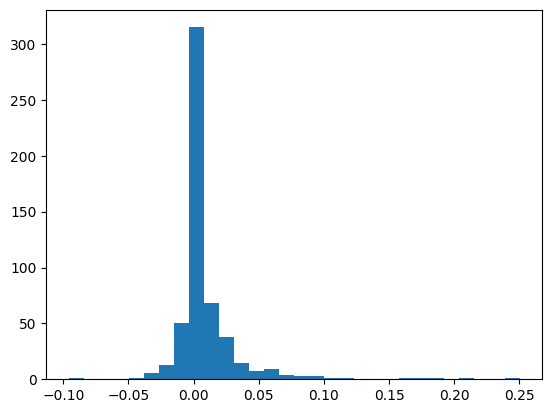

KstestResult(statistic=0.4820041092625368, pvalue=5.875767661667861e-116, statistic_location=-0.03583286684821552, statistic_sign=-1)
KstestResult(statistic=0.4432314602216445, pvalue=3.5459335812462885e-97, statistic_location=-0.06342775882095542, statistic_sign=-1)


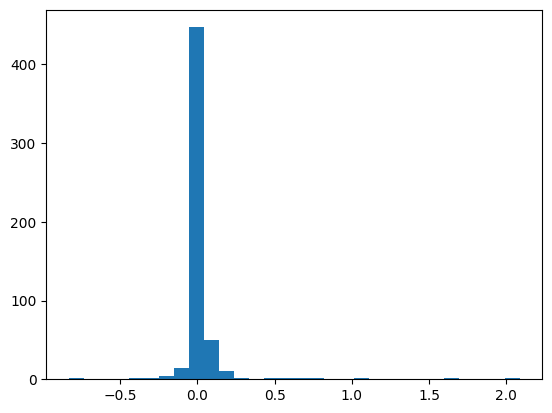

In [30]:
logged_differences = np.log(np.array(RMSE_ARIMA)) - np.log(np.array(RMSE_AR))
plt.hist(logged_differences, bins=30)
plt.show()
plt.hist(np.array(PIS_ARIMA) - np.array(PIS_AR), bins=30)
print(stats.kstest(logged_differences, stats.norm.cdf))
print(stats.kstest(np.array(PIS_ARIMA) - np.array(PIS_AR), stats.norm.cdf))

#### Not normal data, so will use bootstrapping

In [31]:
def bootstrap_metric_mean(metric_list, N, n):
    mean_list = []
    for i in range(N):
        boot = np.random.choice(metric_list, n)
        mean_list.append(np.mean(boot))
    return mean_list

ARIMA_RMSE_boot = bootstrap_metric_mean(RMSE_ARIMA, 100000, 2000)
ARIMA_RMSE_CI = (np.percentile(ARIMA_RMSE_boot, 2.5), np.percentile(ARIMA_RMSE_boot, 97.5))

AR_RMSE_boot = bootstrap_metric_mean(RMSE_AR, 100000, 2000)
AR_RMSE_CI = (np.percentile(AR_RMSE_boot, 2.5), np.percentile(AR_RMSE_boot, 97.5))

print(f"95% CI for ARIMA RMSE: {ARIMA_RMSE_CI}")
print(f"95% CI for AR RMSE: {AR_RMSE_CI}")

95% CI for ARIMA RMSE: (4.694319835655117, 6.1518073134751745)
95% CI for AR RMSE: (4.638744576798997, 6.091524661298081)


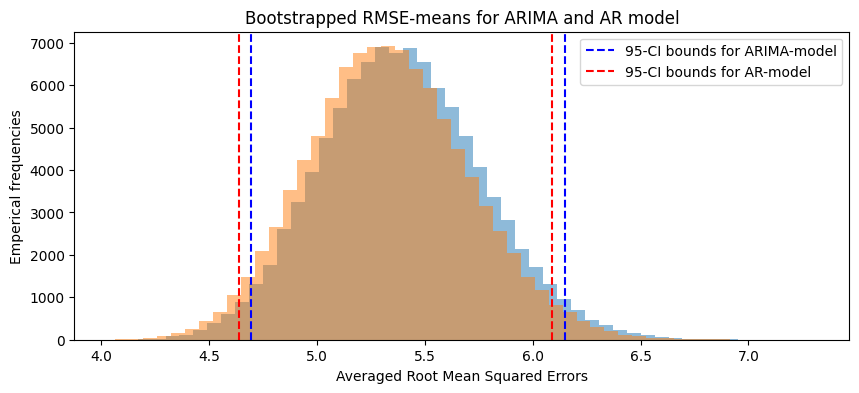

In [32]:
plt.figure(figsize=(10,4))
plt.hist(ARIMA_RMSE_boot, bins=50, alpha=0.5)
plt.axvline(ARIMA_RMSE_CI[0], color='blue', linestyle='--', label="95-CI bounds for ARIMA-model")
plt.axvline(ARIMA_RMSE_CI[1], color='blue', linestyle='--')

plt.hist(AR_RMSE_boot, bins=50, alpha=0.5)
plt.axvline(AR_RMSE_CI[0], color='red', linestyle='--', label="95-CI bounds for AR-model")
plt.axvline(AR_RMSE_CI[1], color='red', linestyle='--')

plt.title("Bootstrapped RMSE-means for ARIMA and AR model")
plt.ylabel("Emperical frequencies")
plt.xlabel("Averaged Root Mean Squared Errors")
plt.legend();

In [33]:
ARIMA_PIS_boot = bootstrap_metric_mean(PIS_ARIMA, 100000, 2000)
ARIMA_PIS_CI = (np.percentile(ARIMA_PIS_boot, 2.5), np.percentile(ARIMA_PIS_boot, 97.5))

AR_PIS_boot = bootstrap_metric_mean(PIS_AR, 100000, 2000)
AR_PIS_CI = (np.percentile(AR_PIS_boot, 2.5), np.percentile(AR_PIS_boot, 97.5))

print(f"95% CI for ARIMA RMSE: {ARIMA_PIS_CI}")
print(f"95% CI for AR RMSE: {AR_PIS_CI}")

95% CI for ARIMA RMSE: (0.8485802992110207, 1.1214557935361404)
95% CI for AR RMSE: (0.8315571971448301, 1.1042967807866784)


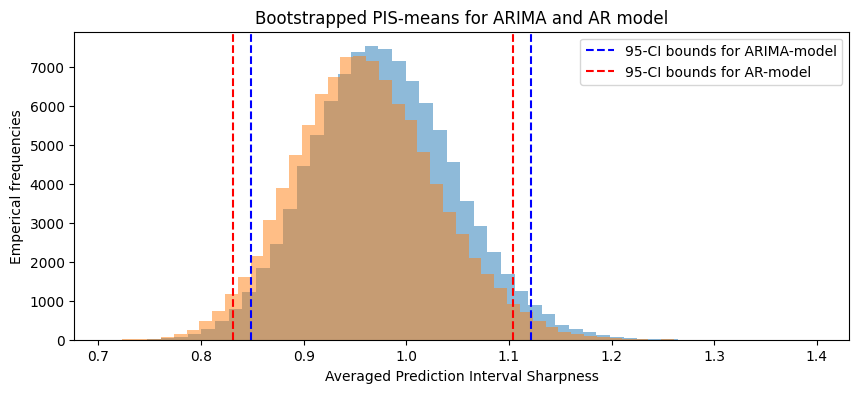

In [34]:
plt.figure(figsize=(10,4))
plt.hist(ARIMA_PIS_boot, bins=50, alpha=0.5)
plt.axvline(ARIMA_PIS_CI[0], color='blue', linestyle='--', label="95-CI bounds for ARIMA-model")
plt.axvline(ARIMA_PIS_CI[1], color='blue', linestyle='--')

plt.hist(AR_PIS_boot, bins=50, alpha=0.5)
plt.axvline(AR_PIS_CI[0], color='red', linestyle='--', label="95-CI bounds for AR-model")
plt.axvline(AR_PIS_CI[1], color='red', linestyle='--')

plt.title("Bootstrapped PIS-means for ARIMA and AR model")
plt.ylabel("Emperical frequencies")
plt.xlabel("Averaged Prediction Interval Sharpness")
plt.legend();

In [35]:
RMSE_diff_boot = bootstrap_metric_mean(np.array(RMSE_ARIMA) - np.array(RMSE_AR), 10000, 2000)
RMSE_diff_CI = (np.percentile(RMSE_diff_boot, 2.5), np.percentile(RMSE_diff_boot, 97.5))

print(f"95% CI for RMSE Difference (ARIMA - AR): {RMSE_diff_CI}")

95% CI for RMSE Difference (ARIMA - AR): (0.043144743074031544, 0.0873936855034731)


## Interpretation
From the bootstrap it is clear that it can not be decisively said that one of the two models performs better than the other.